In [1]:
import re
import pandas as pd

# PDF
from PyPDF2 import PdfReader

import plotly.express as px

In [2]:
def page_clean(text):
    page_data = []

    try:
        group, gender = re.search(r'GROUP :(.+)\[\s+(MALE|FEMALE)\s+\]',
                                  text).groups()
        group, gender = map(str.strip, [group, gender])
    except:
        return page_data

    text = re.split(r'(\={2,})+', text)[4]

    text = re.split(r'(\-{2,})+', text)
    for line in text:
        line = line.strip()
        if re.match('^[\d+]', line):
            line_d = []
            for cell in line.split('  '):
                cell = cell.strip()
                if cell:
                    line_d.append(cell)

            line_d.append(group)
            line_d.append(gender)

            page_data.append(line_d)
    return page_data


def pdf_extract(filename):
    reader = PdfReader(filename)
    number_of_pages = len(reader.pages)

    all_page_data = []
    for page_no in range(number_of_pages):
        #for page_no in range(6,10):
        page = reader.pages[page_no]
        text = page.extract_text()

        page_data = page_clean(text)
        if page_data:
            all_page_data += page_data
    return all_page_data

# PDF read as string

In [3]:
filename = 'data/ssc-briti-din.pdf'
all_page_data = pdf_extract(filename)

# PDF to DataFrame

In [4]:
df = pd.DataFrame(all_page_data)
df = df.fillna(float('nan'))

# Data Clean

In [5]:
def row_clean(row, last_col):
    if row[last_col] == row[last_col]:
        row[3:6] = ' '.join(row[3:last_col - 1]), row[last_col -
                                                      1], row[last_col]
        for index in range(6, last_col + 1):
            row[index] = float('nan')
    return row


def dataframe_clean(df):
    col = df.shape[1] - 1
    for col_no in range(col, 5, -1):
        df = df.apply(lambda x: row_clean(x, col_no), axis=1)
        df = df.drop(col_no, axis=1)
    return df

In [6]:
df = dataframe_clean(df)

## Drop minor wrong data
- There are 5 wrong data(sample row)
- Not worth to clean it

In [7]:
def drop_wrong_data(df):

    columns = {
        0: 'Merit_Pos',
        1: 'Roll',
        2: 'Name',
        3: 'School',
        4: 'Group',
        5: 'Gender'
    }

    new_df = df[~(df[5] != df[5])].reset_index(drop=True)

    new_df.loc[:, 4] = new_df.loc[:, 4].replace({
        'SCIENCE        Total = 163 ( Male = 82 and Female = 81 )':
        'SCIENCE'
    })

    new_df = new_df.apply(lambda x: pd.Series(map(str.strip, x)), axis=1)
    new_df = pd.DataFrame(new_df)

    new_df = new_df.rename(columns=columns)
    new_df = new_df.sort_values(
        by=['School', 'Group', 'Merit_Pos']).reset_index(drop=True)

    return new_df

## Clean DataFrame VS Original DataFrame

In [8]:
new_df = drop_wrong_data(df)

df.shape, new_df.shape

((2385, 6), (2380, 6))

In [9]:
new_df.head()

,Merit_Pos,Roll,Name,School,Group,Gender
0,1451,240037,RIFA TASNIM ORIN,ADARSHA HIGH SCHOOL BIRAMPUR,SCIENCE,FEMALE
1,1470,240038,AFSUNNA AKTER AKHI,ADARSHA HIGH SCHOOL BIRAMPUR,SCIENCE,FEMALE
2,0265,510450,SAFIAH MALIAT,"ADARSHA HIGH SCHOOL, RANGPUR",HUMANITIES,FEMALE
3,0297,510451,SABIHA MUSFIRAT,"ADARSHA HIGH SCHOOL, RANGPUR",HUMANITIES,FEMALE
4,1235,227455,MST. SADIKA JAHAN,ADITMARI KANTESWAR BARMAN GIRLS' HIGH SCHOOL &...,SCIENCE,FEMALE


# Data Visualize

In [10]:
def frequency_count(df):
    count_val = df.Gender.count()
    return count_val


def create_new_col(df, col1, col2):
    total = df.groupby([col1]).apply(lambda df: df[col2].sum()).to_dict()
    df['Total'] = df.apply(lambda x: total[x[col1]], axis=1)
    return df


def generate_fig(df,
                 group_by,
                 col_name,
                 fig_attr={},
                 asscending=None,
                 top_k=None):
    fill_df = df.groupby(group_by).apply(frequency_count)
    fill_df = fill_df.to_frame(name=col_name).reset_index()

    if asscending is not None:
        sort_col = col_name
        if len(group_by) > 1:
            fill_df = create_new_col(fill_df, group_by[0], col_name)
            sort_col = 'Total'

        fill_df = fill_df.sort_values(by=sort_col, ascending=asscending)

    if top_k:
        fill_df = fill_df.iloc[:top_k]

    fig = px.bar(fill_df, x=group_by[0], y=col_name, **fig_attr)
    return fig

## Total Scholarship grouped by Gender

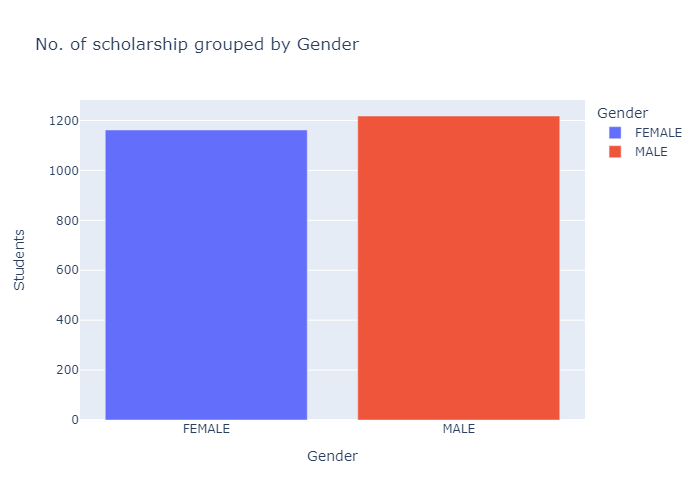

In [11]:
group_by = ['Gender']
col_name = 'Students'
fig_attr = {'color': 'Gender', 'title': 'No. of scholarship grouped by Gender'}

fig = generate_fig(new_df, group_by, col_name, fig_attr)
fig.show('png')

## Total Scholarship grouped by Major

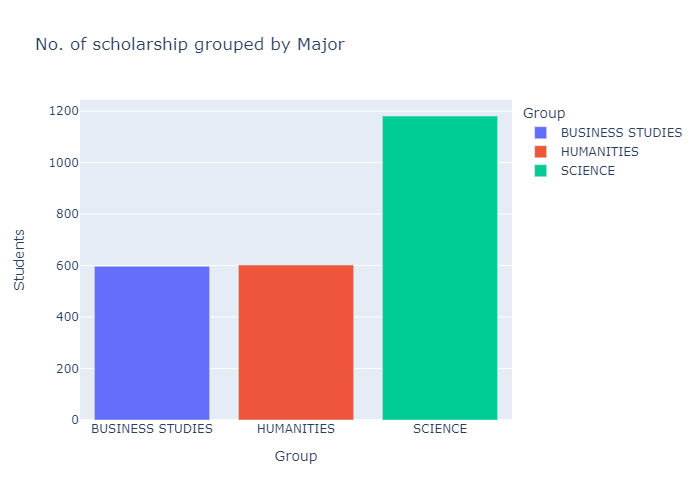

In [12]:
group_by = ['Group']
col_name = 'Students'
fig_attr = {'color': 'Group', 'title': 'No. of scholarship grouped by Major'}

fig = generate_fig(new_df, group_by, col_name, fig_attr)
fig.show('png')

## Total Scholarship grouped by Major & Gender

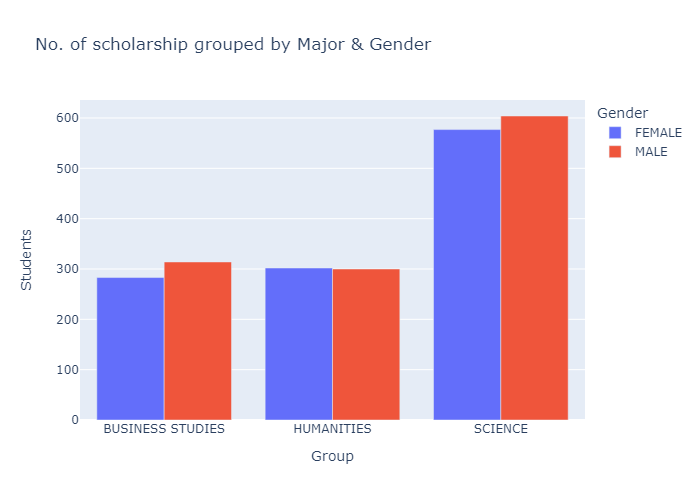

In [13]:
group_by = ['Group', 'Gender']
col_name = 'Students'
fig_attr = {
    'color': 'Gender',
    'barmode': 'group',
    'title': 'No. of scholarship grouped by Major & Gender'
}

fig = generate_fig(new_df, group_by, col_name, fig_attr)
fig.show('png')

## Total Scholarship grouped by School

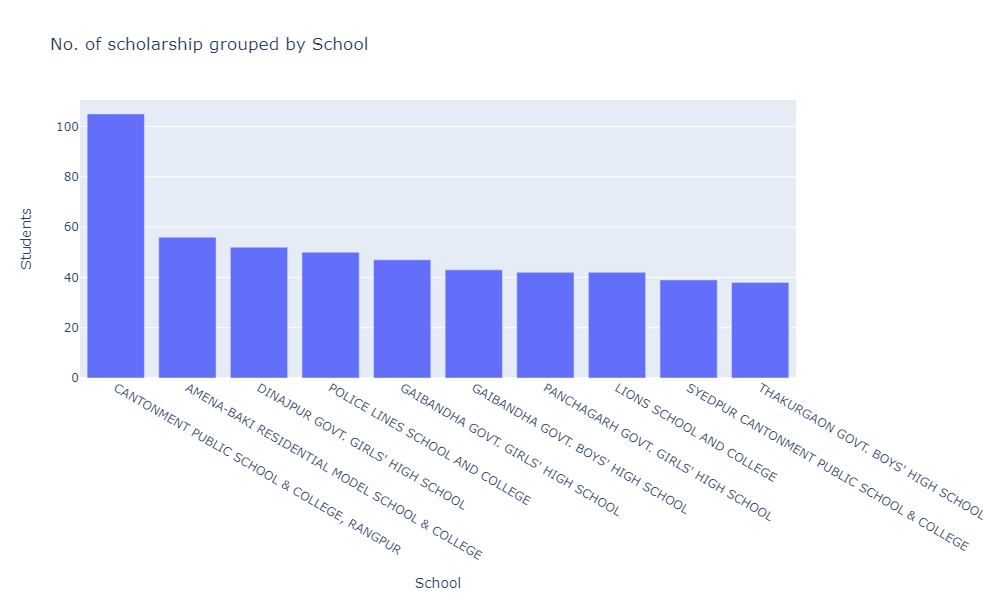

In [14]:
group_by = ['School']
col_name = 'Students'
asscending = False
fig_attr = {
    'title': 'No. of scholarship grouped by School',
    'width': 1000,
    'height': 600
}
top_k = 10
fig = generate_fig(new_df, group_by, col_name, fig_attr, asscending, top_k)
fig.show('png')

## Total Scholarship grouped by School [MALE]

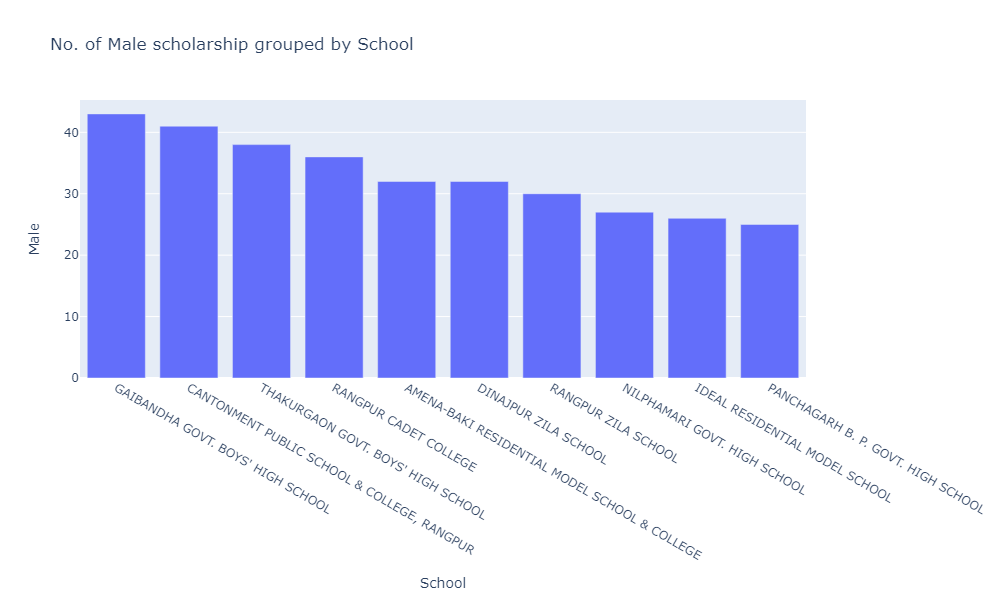

In [15]:
group_by = ['School']
col_name = 'Male'
asscending = False
fig_attr = {
    'title': 'No. of Male scholarship grouped by School',
    'width': 1000,
    'height': 600
}
top_k = 10

male_df = new_df[new_df.Gender == 'MALE']
fig = generate_fig(male_df, group_by, col_name, fig_attr, asscending, top_k)
fig.show('png')

## Total Scholarship grouped by School [FEMALE]

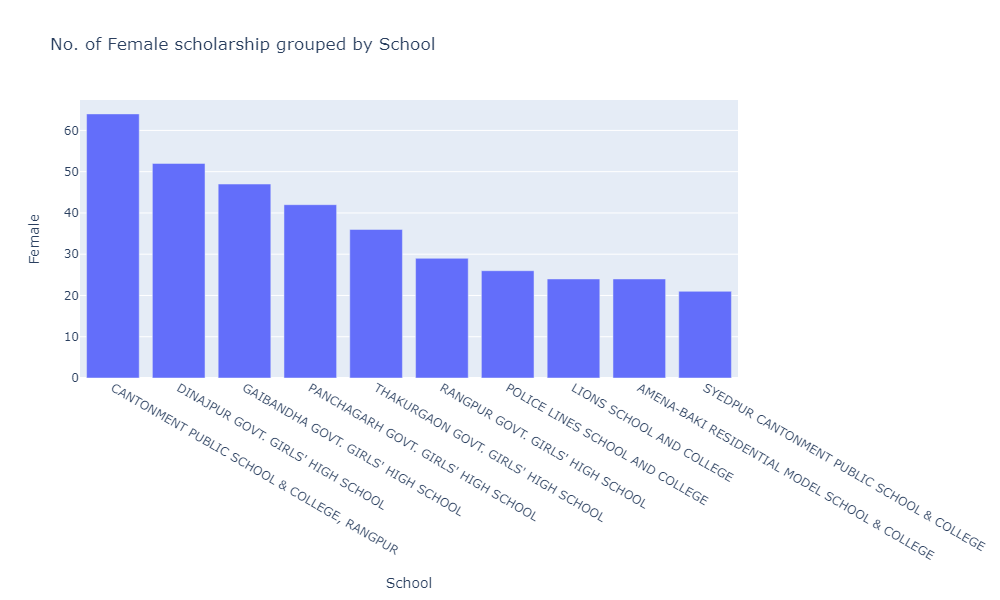

In [16]:
group_by = ['School']
col_name = 'Female'
asscending = False
fig_attr = {
    'title': 'No. of Female scholarship grouped by School',
    'width': 1000,
    'height': 600
}
top_k = 10

female_df = new_df[new_df.Gender == 'FEMALE']
fig = generate_fig(female_df, group_by, col_name, fig_attr, asscending, top_k)
fig.show('png')

## Top Schools Scholarship ratio [Male VS Female]

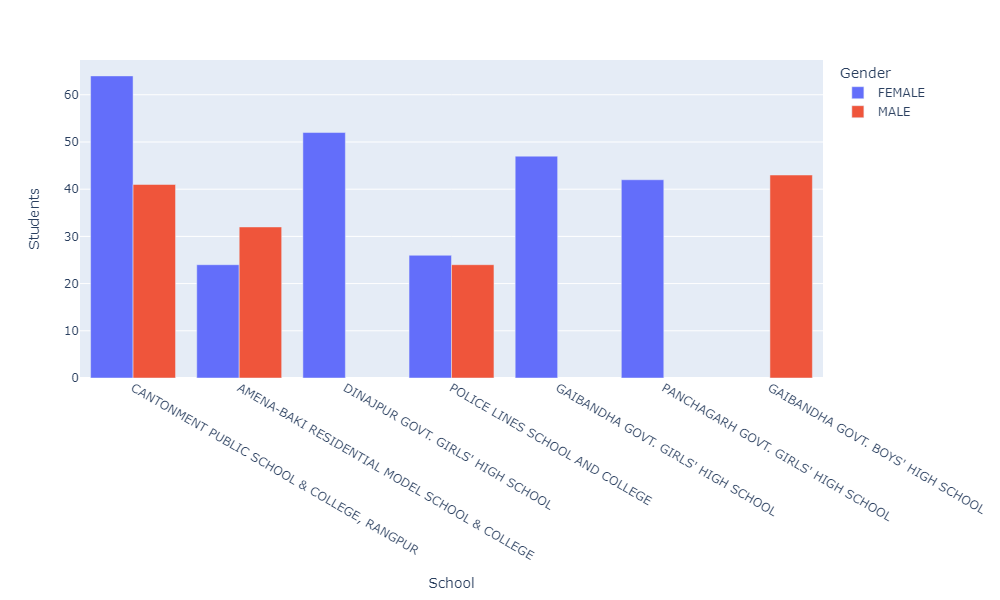

In [17]:
group_by = ['School', 'Gender']
col_name = 'Students'
asscending = False
top_k = 10

fig_attr = {
    'color': 'Gender',
    'barmode': 'group',
    'width': 1000,
    'height': 600
}
fig = generate_fig(new_df,
                   group_by,
                   col_name,
                   fig_attr,
                   asscending=asscending,
                   top_k=top_k)
fig.show('png')

## No. of scholarship for top ranked students

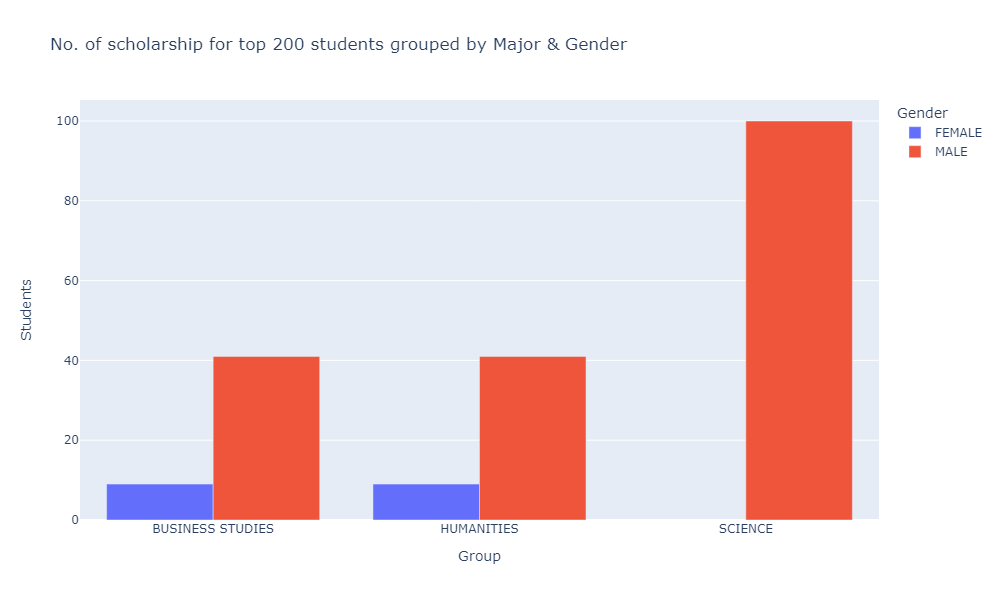

In [18]:
group_by = ['Group', 'Gender']
col_name = 'Students'
top_merit = 200

fig_attr = {
    'color': 'Gender',
    'barmode': 'group',
    'title': f'No. of scholarship for top {top_merit} students grouped by Major & Gender',
    'width': 1000,
    'height': 600
}

top_students = new_df.sort_values(by=['Merit_Pos']).reset_index(
    drop=True).iloc[:top_merit]
fig = generate_fig(top_students, group_by, col_name, fig_attr)
fig.show('png')